# Ray Serve - Model Serving Challenges

© 2019-2022, Anyscale. All Rights Reserved

📖 [Back to Table of Contents](./ex_00_tutorial_overview.ipynb)<br>
➡ [Next notebook](./ex_02_ray_serve_fastapi.ipynb) <br>

### Learning Objective:
In this introductory tutorial, you will:

* Learn about model serving challenges
* Understand Ray Architecture
* Explore the fundamentals of Deployments

## The Challenges of Model Serving

Model development happens in a data science research environment. There are many challenges, such as feature engineering, model selection, missing or messy data, yet there are tools at the data scientists' disposal. By contrast, model deployment to production faces an entirely different set of challenges and requires different tools. We must bridge the divide as much as possible.

So what are some of the challenges of model serving?

<img src="images/serve_challenges.png" width="70%" height="40%">

### 1. It Should Be Framework Agnostic

First, model serving frameworks must be able to serve models from popular frameworks and libraries like TensorFlow, PyTorch, scikit-learn, or even arbitrary Python functions. Even within the same organization, it is common to use several machine learning frameworks, in order to get the best model. 

Second, machine learning models are typically surrounded by (or work in conjunction with) 
lots of application or business logic. For example, some model serving is implemented as a RESTful service to which scoring requests are made. Often this is too restrictive, as some additional processing, such as fetching additional data from a online feature store, to augment the request data, may be desired as part of the scoring process, and the performance overhead of remote calls may be suboptimal.

### 2. Pure Python or Pythonic

In general, model serving should be intuitive for developers and simple to configure and run. Hence, it is desirable to use pure Python and to avoid verbose configurations using YAML files or other means. 

Data scientists and engineers use Python and Python-based ML frameworks to develop their machine learning models, so they should also be able to use Python to deploy their machine learning applications. This need is growing more critical as online learning applications combine training and serving in the same applications.

### 3. Simple and Scalable

Model serving must be simple to scale on demand across many machines. It must also be easy to upgrade models dynamically, over time. Achieving production uptime and performance requirements are essential for success.

### 4. DevOps/MLOps Integrations

Model serving deployments need to integrate with existing "DevOps" CI/CD practices for controlled, audited, and predicatble releases. Patterns like [Canary Deployment](https://martinfowler.com/bliki/CanaryRelease.html) are particularly useful for testing the efficacy of a new model before replacing existing models, just as this pattern is useful for other software deployments.

### 5. Flexible Deployment Patterns

There are unique deployment patterns, too. For example, it should be easy to deploy a forest of models, to split traffic to different instances, and to score data in batches for greater efficiency.

See also this [Ray blog post](https://medium.com/distributed-computing-with-ray/the-simplest-way-to-serve-your-nlp-model-in-production-with-pure-python-d42b6a97ad55) on the challenges of model serving and the way Ray Serve addresses them. It also provides an example of starting with a simple model, then deploying a more sophisticated model into the running application. Along the same lines, this blog post, [Serving ML Models in Production Common Patterns](https://www.anyscale.com/blog/serving-ml-models-in-production-common-patterns) discusses how deployment patterns for model serving and how you can use Ray Serve. Additionally, listen to this webinar: [Building a scalable ML model serving API with Ray Serve](https://www.anyscale.com/events/2021/09/09/building-a-scalable-ml-model-serving-api-with-ray-serve). This introductory webinar highlights how Ray Serve makes it easy to deploy, operate and scale a machine learning API.

<img src="images/PatternsMLProduction.png" width="70%" height="40%"> 


## Why Ray Serve?

[Ray Serve](https://docs.ray.io/en/latest/serve/index.html) is a scalable, framework-agnostic and Python-first model serving library built on [Ray](https://ray.io).

<img src="images/ray_serve_overview.png" width="70%" height="40%"> 

For users, Ray Serve offers these benefits:

* **Framework Agnostic**: You can use the same toolkit to serve everything from deep learning models built with [PyTorch](https://docs.ray.io/en/latest/serve/tutorials/pytorch.html#serve-pytorch-tutorial), [Tensorflow](https://docs.ray.io/en/latest/serve/tutorials/tensorflow.html#serve-tensorflow-tutorial), or [Keras](https://docs.ray.io/en/latest/serve/tutorials/tensorflow.html#serve-tensorflow-tutorial), to [scikit-Learn](https://docs.ray.io/en/latest/serve/tutorials/sklearn.html#serve-sklearn-tutorial) models, to arbitrary business logic.
* **Python First:** Configure your model serving with pure Python code. No YAML or JSON configurations required.

Since Serve is built on Ray, it also allows you to scale to many machines, in your datacenter or in cloud environments, and it allows you to leverage all of the other Ray frameworks.

## Ray Serve Architecture and components

<img src="images/serve-architecture-2.0.png" height="40%" width="70%">

There are three kinds of actors that are created to make up a Serve instance:
- **Controller**: A global actor unique to each Serve instance that manages
  the control plane. The Controller is responsible for creating, updating, and
  destroying other actors. Serve API calls like creating or getting a deployment
  make remote calls to the Controller.
- **HTTP Proxy**: By default there is one HTTP proxy actor on the head node. This actor runs a [Uvicorn](https://www.uvicorn.org/) HTTP
  server that accepts incoming requests, forwards them to replicas, and
  responds once they are completed.  For scalability and high availability,
  you can also run a proxy on each node in the cluster via the `location` field of [`http_options`](core-apis).
- **Replicas**: Actors that actually execute the code in response to a
  request. For example, they may contain an instantiation of an ML model. Each
  replica processes individual requests from the HTTP proxy (these may be batched
  by the replica using `@serve.batch`, see the [batching](https://docs.ray.io/en/latest/serve/ml-models.html#serve-batching) docs).

For more details, see this [key concepts](https://docs.ray.io/en/latest/serve/index.html) and [architecture](https://docs.ray.io/en/latest/serve/architecture.html) documentation.

### Lifetime of a Request

When an HTTP request is sent to the router, the following things happen:

 * The HTTP request is received and parsed.

 * The correct deployment associated with the HTTP url path is looked up. The request is placed on a queue.

 * For each request in a deployment queue, an available replica is looked up and the request is sent to it. If there are no available replicas (there are more than max_concurrent_queries requests outstanding), the request is left in the queue until an outstanding request is finished.

Each replica maintains a queue of requests and executes one at a time, possibly using asyncio to process them concurrently. If the handler (the function for the deployment or __call__) is async, the replica will not wait for the handler to run; otherwise, the replica will block until the handler returns.



# Simple Ray Serve Examples

__Deployments__ are the basic unit of request handling in Serve. Each Deployment maintains multiple identical _replicas_, and forwards requests at random to each one. Deployments scale by adding more replicas to respond to traffic faster.

In this lesson, we will explore the fundamentals of Deployments. All of the other concepts in Serve build on top of deployments, so it is important to understand them well! 

If this all feels a bit basic, don't worry: we'll build a functional ML Pipeline later in the course, and handle details such as HTTP parsing and model composition. For now, let's see how Ray Serve makes deployments simple! 

## Setup

In [94]:
# Library imports
import os
import warnings
import time
import logging

In [95]:
# Ray imports
import ray
from ray import serve

In [96]:
# Environment setup
warnings.filterwarnings("ignore")
os.environ["PYTHONWARNINGS"] = "ignore"

In [97]:
# Start ray
if ray.is_initialized:
    ray.shutdown()
ray.init(logging_level=logging.ERROR)

Python version:,3.7.7
Ray version:,3.0.0.dev0
Dashboard:,http://172.18.0.35:8265


## Hello World: A minimal example

### Define

Let's define our first deployment. The `@serve.deployment` decorator transforms a python function into a deployment. In this case, the `hello()` function will be invoked when the `/hello` HTTP endpoint is hit.

The `hello` deployment just says "Hello World!"

Let's define our first deployment. The `@serve.deployment` decorator transforms a python function into a deployment. This  In this case, the `hello()` function will be invoked when the HTTP end

The `hello` deployment just says "Hello World!"

In [98]:
@serve.deployment
def hello():
    return "Hello World!"

### Deploy 

Let's deploy our model using Ray Serve.

First call `hello.bind()` to get a lazy handle to the deployment.

In [41]:
lazy_handle = hello.bind()

Then call `serve.run` to start a server listening on `localhost:8000`, register the `hello` deployment to handle requests sent to the `/hello` endpoint, and to get a live handle to the running deployment.

In [42]:
hello_handle = serve.run(lazy_handle)

Finally, run `serve status` from the command line to see the status of the deployment!

In [44]:
%%bash

# Help Jupyter find the serve CLI
export PATH="/home/ray/anaconda3/bin:$PATH"

serve status

app_status:
  status: RUNNING
  message: ''
  deployment_timestamp: 0.0
deployment_statuses:
- name: hello
  status: HEALTHY
  message: ''



You should see output similar to the text below if your deployment worked.

### Query

There are 2 ways to query a deployment with Ray Serve. You can either use the handle or send an HTTP request to the appropriate endpoint. In this case, we need to send a GET request to `http://localhost:8000/hello` to hit our endpoint. 

#### Query with Ray API

In [48]:
# Query using Ray handle
await hello_handle.remote()

'Hello World!'

#### Query with the HTTP API

In [50]:
# Use the requests library
import requests


# Ray Serve runs on port 8000 by default
SERVE_URL = "http://localhost:8000"

def http_get(path: str):
    """Send a GET request with the requests library"""
    return requests.get(SERVE_URL + path).text

# Query using HTTP
http_get('/hello')

'Hello World!'

### Query with Command Line

In [104]:
%%bash
wget -O - 'http://localhost:8000/hello' 

Hello from BiggerFasterFibonacci! The 32nd fibonacci number is 3524578

--2022-08-11 21:28:14--  http://localhost:8000/hello
Resolving localhost (localhost)... 127.0.0.1, ::1
Connecting to localhost (localhost)|127.0.0.1|:8000... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/plain]
Saving to: ‘STDOUT’

     0K                                                        9.73M=0s

2022-08-11 21:28:15 (9.73 MB/s) - written to stdout [70]



That's it! We have successfully created, deployed, and queried a minimal model using Ray Serve. 

## Fibonacci: Scaling a simple compute intensive task

In this example, we will demonstrate how Ray Serve makes it easy to scale compute intensive workloads across multiple CPUs. We will use a toy Fibonacci example to show how Serve supports initializing a model at deploy time, and then running compute intensive inferences with that model at request time.

**Problem**: Create a deployment that
1. At initialization: Accepts a name and records it. Initialize a ComputeIntensiveModel
2. At query time: Run the `ComputeIntensiveModel.forward()` helper function, and return the result, along with it's name.
3. Handles 3 QPS

`ComputeIntensiveModel.forward()` calculates a large fibonacci number (very) inefficiently to simulate running inference on a large ML model. It is CPU bound, and consumes real CPU resources. 

Most other python serving frameworks optimize QPS by concurrently handling several requests on a single CPU, which works well for IO-bound tasks that have a lot of idle time. This approach doesn't help scale CPU-bound workloads. The only way to scale CPU-bound workloads to high QPS is to use more CPUs.


In this example, we show how Ray Serve makes it easy to scale to leverage more compute and deliver higher QPS on compute bound tasks.

Let's start by timing `ComputeIntensiveModel.forward()`.

In [83]:
from helper import ComputeIntensiveModel

model = ComputeIntensiveModel()
%timeit model.forward()

1.17 s ± 27.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Each invocation should take around 1.2 seconds to run.

### Define

We can use our `serve.deployment` decorator on a class. The initializer of the class will be called at __deploy__ time, and the `__call__` magic method will be called when the deployment receives a request. 

Let's initialize our model in the initializer, and then call `model.forward()` function to the `__call__` method. 

In [68]:
from helper import compute_intensive_workload

@serve.deployment
class Fibonacci:
    def __init__(self, name):
        self.name = name
        self.model = ComputeIntensiveModel()

    def __call__(self):
        return f"Hello from {self.name}! " + self.model.forward()

### Deploy

Let's deploy `Fibonacci` with 1 replica. We specify the number of replicas in the `.options()` method on the class. We then pass the constructor arguments, in this case just `name`, to the `.bind()` function to obtain a lazy handle. As before, calling `serve.run` will deploy our model and return a live handle.

In [69]:
lazy_handle = Fibonacci.options(num_replicas=1).bind(name="Fibonacci")
fib_handle = serve.run(lazy_handle)

Let's check the status again to make sure our model is deployed.

In [70]:
%%bash
# Help Jupyter find the serve CLI
export PATH="/home/ray/anaconda3/bin:$PATH"

serve status

app_status:
  status: RUNNING
  message: ''
  deployment_timestamp: 0.0
deployment_statuses:
- name: Fibonacci
  status: HEALTHY
  message: ''



### Query

We can reuse the `http_get` helper defined in the previous section to send an HTTP request to our deployment.

In [100]:
http_get('/Fibonacci')

'Hello from BiggerFasterFibonacci! The 32nd fibonacci number is 3524578'

### Measuring QPS

Let's run a load test against our deployment to measure QPS. 

We will use the `load_test` function from the helper file, which hits a specified endpoint with a specified number of concurrent requests and returns the measured QPS.

In [73]:
from helper import load_test

# Run 10 queries in parallel and calculate QPS for 1 replica
qps_1 = await load_test('/Fibonacci', 10)

Running load test: 100%|██████████| 10/10 [00:11<00:00,  1.18s/it]

Sent 10 requests in 11.824367761611938. 0.846 QPS average. 1.182s per request.


We only have 1 replica, so we are only able to serve a little less than 1 QPS.  

## Scaling Up

Now for the fun part! Let's scale up the Fibonacci model to improve throughput. We want to hit 3 QPS, so we will need roughly 5 replicas. Let's also increase the number of requests sent to get a more accurate measurement.

In [93]:
# Scale up
num_replicas = 5
lazy_handle = Fibonacci.options(num_replicas=num_replicas).bind(name="BiggerFasterFibonacci")
serve.run(lazy_handle)

# Rerun the load test
qps_5 = await load_test('/Fibonacci', 20)

2022-08-11 20:46:51,715	INFO worker.py:1203 -- Using address localhost:9031 set in the environment variable RAY_ADDRESS
2022-08-11 20:46:51,717	INFO worker.py:1312 -- Connecting to existing Ray cluster at address: 172.18.0.35:9031...
2022-08-11 20:46:51,723	INFO worker.py:1487 -- Connected to Ray cluster. View the dashboard at 172.18.0.35:8265.
(ServeController pid=2055228) INFO 2022-08-11 20:46:53,585 controller 2055228 http_state.py:132 - Starting HTTP proxy with name 'SERVE_CONTROLLER_ACTOR:SERVE_PROXY_ACTOR-1ee37389f2213fec8190af7a2e84cfd9b79f1d83aec9ece89cdbab04' on node '1ee37389f2213fec8190af7a2e84cfd9b79f1d83aec9ece89cdbab04' listening on '127.0.0.1:8000'
(ServeController pid=2055228) INFO 2022-08-11 20:46:55,544 controller 2055228 deployment_state.py:1233 - Adding 5 replicas to deployment 'Fibonacci'.
(HTTPProxyActor pid=2055271) INFO:     Started server process [2055271]
Running load test:   5%|▌         | 1/20 [00:01<00:27,  1.44s/it](HTTPProxyActor pid=2055271) INFO 2022-08

Sent 20 requests in 6.8648200035095215. 2.913 QPS average. 0.343s per request.



(HTTPProxyActor pid=2055271) INFO 2022-08-11 20:47:06,372 http_proxy 172.18.0.35 http_proxy.py:320 - GET / 200 6852.0ms
(HTTPProxyActor pid=2055271) INFO 2022-08-11 20:47:06,373 http_proxy 172.18.0.35 http_proxy.py:320 - GET / 200 6847.9ms
(HTTPProxyActor pid=2055271) INFO 2022-08-11 20:47:06,373 http_proxy 172.18.0.35 http_proxy.py:320 - GET / 200 6848.0ms
(ServeReplica:Fibonacci pid=2055320) INFO 2022-08-11 20:47:06,371 Fibonacci Fibonacci#ygQSdT replica.py:487 - HANDLE __call__ OK 1325.7ms
(ServeController pid=2055228) 2022-08-11 20:47:33,315	INFO (unknown file):0 -- Task failed with unretryable exception: TaskID(df6fb3677751f87522a4ad49b65d0cb1bc94108d15000000).
(ServeController pid=2055228) Traceback (most recent call last):
(ServeController pid=2055228)   File "python/ray/_raylet.pyx", line 709, in ray._raylet.execute_task
(ServeController pid=2055228)   File "python/ray/_raylet.pyx", line 713, in ray._raylet.execute_task
(ServeController pid=2055228)   File "python/ray/_raylet.

That's a pretty big improvement! We are just about hitting 3 QPS now. Let's calculate the improvements and make a plot.

3.11x improvement from scaling to 5 replicas


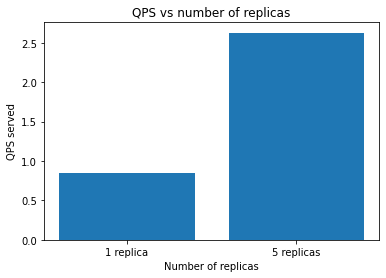

In [91]:
improvement = round(qps_5 / qps_1, 2)
print(f"{improvement}x improvement from scaling to {num_replicas} replicas")

# Plot the improvement using matplotlib
import matplotlib.pyplot as plt
plt.clf()
plt.bar(["1 replica", f"{num_replicas} replicas"], [qps_1, qps_5])
plt.xlabel("Number of replicas")
plt.ylabel("QPS served")
plt.title("QPS vs number of replicas")
plt.show()

Wow! That's a significant QPS improvement. Thanks to Ray, Serve can scale to hundreds of replicas to handle high QPS applications for compute intensive tasks.

### Shut down Ray Serve

In [92]:
serve.shutdown()
ray.shutdown()

# Exercises

Here are some exercises to become more familiar with Ray Serve:

1. Try different numbers of replicas. Is there a limit to how high the QPS can go? Why?
2. What is the overhead of sending a request via HTTP vs using the handle directly? 
3. Do requests get sent to different replicas? (check the Ray Dashboard)
4. Write your own Serve Deployment and run it.

### Homework

* Try the tutorials below with Ray Serve

### Framework-Specific Tutorials

Ray Serve seamlessly integrates with popular Python ML libraries. Below are tutorials with some of these frameworks to help get you started.

 * [PyTorch Tutorial](https://docs.ray.io/en/latest/serve/tutorials/pytorch.html#serve-pytorch-tutorial)
 * [Scikit-Learn Tutorial](https://docs.ray.io/en/latest/serve/tutorials/sklearn.html#serve-sklearn-tutorial)
 * [Keras and Tensorflow Tutorial](https://docs.ray.io/en/latest/serve/tutorials/tensorflow.html#serve-tensorflow-tutorial)
 * [Ray Serve MLflow Deployment Plugin](https://github.com/ray-project/mlflow-ray-serve)


### Next
We will learn how you can use Ray Serve integration with [MLflow](https://mlflow.org/)

📖 [Back to Table of Contents](./ex_00_tutorial_overview.ipynb)<br>
➡ [Next notebook](./ex_02_ray_serve_fastapi.ipynb) <br>
